In [1]:
import numpy as np
import matplotlib.pyplot as plt
from openmolecularsystems.systems import TwoLJParticles
from openmolecularsystems.tools.md import langevin_NVT
import simtk.unit as unit
import molsysmt as msm
from tqdm import tqdm

# La termodinámica del proceso asociación-disociación de dos partículas LJ

Recordemos que estamos definiendo el sistema de dos partículas de Lennard-Jones en una caja cúbica con condiciones de contorno periódicas con los siguientes parámetros:

In [2]:
# Particula A
mass_A = 40.0 * unit.amu
sigma_A = 2.0 * unit.angstroms
epsilon_A = 2.0 * unit.kilocalories_per_mole

# Particula B
mass_B = 120.0 * unit.amu
sigma_B = 4.0 * unit.angstroms
epsilon_B = 4.5 * unit.kilocalories_per_mole

# Box
Lbox = 5.0*unit.nanometers
box = np.zeros((3, 3))*unit.nanometers
box[0,0] = Lbox
box[1,1] = Lbox
box[2,2] = Lbox

El potencial Lennard-Jonnes entre las partículas se define mediante la expresión:

\begin{equation}
V(l) = 4 \epsilon_{red} \left[ \left( \frac{\sigma_{red}}{l} \right)^{12} - \left( \frac{\sigma_{red}}{l} \right)^{6} \right]
\end{equation}

Donde $l$ es la distancia entre las partículas A y B en el espacio periódico cúbico de lado $L_{box}$:

\begin{equation}
dist(\vec{r}_{A},\vec{r}_{B}) = \sqrt{\theta(x_{A},x_{B})^2+\theta(y_{A},y_{B})^2+\theta(z_{A},z_{B})^2}
\end{equation}

con

\begin{equation}
\theta(q_{A},q_{B}) =
\begin{cases}
q_{B}-q_{A}-L_{box} \;\;\;\; \rm{si} \;\;\; \frac{L_{box}}{2}<(q_{B}-q_{A}) \\
q_{B}-q_{A}+L_{box} \;\;\;\; \rm{si} \;\;\; (q_{B}-q_{A})\leq-\frac{L_{box}}{2} \\
q_{B}-q_{A} \;\;\;\; \rm{si} \;\;\; -\frac{L_{box}}{2}<(q_{B}-q_{A})\leq\frac{L_{box}}{2}
\end{cases}
\end{equation}

y los parámetros reducidos del potencial se construyen desde los parámetros de las partículas de la siguiente manera:



\begin{equation}
\sigma_{red} = \frac{\sigma_{A}+\sigma_{B}}{2}
\end{equation}

\begin{equation}
\epsilon_{red} = \sqrt{\epsilon_{A}\epsilon_{B}}
\end{equation}



Supongamos ahora que queremos conocer la probabilidad de que ambas partículas se encuentren "unidas" o "asociadas" a la temperatura de 300K.

In [3]:
# Estado termodinámico
temperature = 300*unit.kelvin
KbT = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA * temperature

Podemos calcular la probabilidad de encontrar a las dos partículas separadas una distancia $d$ de la siguiente manera:

\begin{equation}
P(l) = \frac{1}{Z_{V}} \iiint_{0.0}^{L_{box}} \iiint_{0.0}^{L_{box}} e^{-\frac{1}{K_{B}T}V(l)} \delta\left(l−dist(\vec{r}_{A}, \vec{r}_{B})\right) \; d\vec{r}_{A} d\vec{r}_{B}
\end{equation}

Siendo la parte del potencial de la función de partición total:

\begin{equation}
Z_{V} = \iiint_{0.0}^{L_{box}} \iiint_{0.0}^{L_{box}} e^{-\frac{1}{K_{B}T}V\left(dist(\vec{r}_{A}, \vec{r}_{B})\right)} \; d\vec{r}_{A} d\vec{r}_{B}
\end{equation}

Esta expresión corresponde a la definición tal cual es. Podemos resolver estas integrales reescribíendolas de manera inteligente, pero antes, intentemos calcular numéricamente $Z_{V}$ de esta manera para que tengas una idea de cuanto tiempo puede costar resolver una integral sexta (considerando todas las conformaciones posibles de dos partículas en tres dimensiones) en Python:

In [4]:
sigma_red = 0.5*(sigma_A+sigma_B)
epsilon_red = np.sqrt(epsilon_A*epsilon_B)

def potential(distance):
    
    global sigma_red, epsilon_red
    
    d_aux = sigma_red/distance
    
    return 4.0*epsilon_red*(d_aux**12-d_aux**6)

def distance_AB_with_PBC(rA, rB, box_length):

    box_half_length=0.5*box_length
    r_ab = rA-rB
    for jj in range(3):
        if r_ab[jj]>box_half_length:
            r_ab[jj]-=box_length
        elif r_ab[jj]<-box_half_length:
            r_ab[jj]+=box_length
        output=(r_ab[0]**2+r_ab[1]**2+r_ab[2]**2)**0.5
    
    return output

In [5]:
def calc_ZV(box_length, n_bins_dimension):
    
    global KbT
    
    dxA=box_length/n_bins_dimension
    dyA=dxA
    dzA=dxA
    dxB=dxA
    dyB=dxA
    dzB=dxA
    dv=dxA*dyA*dzA*dxB*dyB*dzB
    
    rA = np.zeros([3])*unit.nanometers
    rB = np.zeros([3])*unit.nanometers
    
    for ii_A in tqdm(range(n_bins_dimension)):
        rA[0] = ii_A*dxA
        for jj_A in range(n_bins_dimension):
            rA[1] = jj_A*dyA
            for kk_A in range(n_bins_dimension):
                rA[2] = kk_A*dzA
                for ii_B in range(n_bins_dimension):
                    rB[0] = ii_B*dxB
                    for jj_B in range(n_bins_dimension):
                        rB[1] = jj_B*dyB
                        for kk_B in range(n_bins_dimension):
                            rB[2] = kk_B*dzB
                            
                            dist = distance_AB_with_PBC(rA, rB, box_length)
                            if dist<0.00001*unit.nanometers:
                                try:
                                    output+= 0*dv
                                except:
                                    output= 0*dv
                            else:
                                V = potential(dist)
                                try:
                                    output+= np.exp(-V/KbT)*dv
                                except:
                                    output= np.exp(-V/KbT)*dv
    
    return output

In [6]:
ZV = calc_ZV(5.0*unit.nanometers, 10)

100%|██████████| 10/10 [03:29<00:00, 20.99s/it]


In [7]:
ZV

Quantity(value=15781.363589933784, unit=nanometer**6)

En mi laptop este cálculo cuesta un poco más de 4 minutos con una discretización muy pobre, $\Delta x =0.5 \; \rm{nm}$, una resolución espacial mayor incluso que $\sigma_{red}$. Para tener una estimación mínimamente decente tendríamos que al menos hacer divisiones cada angstrom. Estimemos cuanto tiempo costaría este cálculo. 50 divisiones por dimensión significa incrementar en $x5$ cada uno de los 6 bucles. Haríamos entonces $x5^{6}$ iteraciones con respecto al cálculo que hicimos. Veamos cuanto tiempo sería esto:

In [9]:
time=(4*unit.minutes)* 5**6
print(time.in_units_of(unit.days))

43.40277777777778 day


Ahora imagina lo que costaría un cálculo de este tipo si tenemos del orden de 5000 átomos en un caja periódica.

Sucede que para este sistema tenemos todavía recursos para que el cálculo sea sencillo y rápido, en primer lugar se puede demostrar que la probabilidad $P(d)$ se puede reescribir como:


\begin{equation}
P(l) = \frac{1}{Z_{V}} \iiint_{0.0}^{L_{box}} d\vec{r} \iiint_{-L_{box}/2}^{L_{box}/2} e^{-\frac{1}{K_{B}T}V(l)} \delta (l−\lVert \vec{u} \rVert) \; d\vec{u}
\end{equation}

Siendo la parte del potencial de la función de partición total:

\begin{equation}
Z_{V} = \iiint_{0.0}^{L_{box}} d\vec{r} \iiint_{-L_{box}/2}^{L_{box}/2} e^{-\frac{1}{K_{B}T}V(\lVert \vec{u} \rVert)} \; d\vec{u}
\end{equation}

Así que simplificando:

\begin{equation}
P(l) = \frac{1}{\hat{Z}_{V}} \iiint_{-L_{box}/2}^{L_{box}/2} e^{-\frac{1}{K_{B}T}V(l)} \delta (l−\lVert \vec{u} \rVert) \; d\vec{u}
\end{equation}

donde $\hat{Z}_{V}$ es:

\begin{equation}
\hat{Z}_{V} = \iiint_{-L_{box}/2}^{L_{box}/2} e^{-\frac{1}{K_{B}T}V( \lVert \vec{u} \rVert )} \; d\vec{u}
\end{equation}

Hemos reducido las integrales sextuples a integrales triples. Pero todavía podemos hacer más porque nuestras funciones a integrar dependen de un parámetro, la distancia. Pero además el potencial tiende a cero rápidamente, emplear un umbral sobre el cual hacemos cero el potencial, puede ahorrar tiempo de cálculo para obtener $P(d)$:

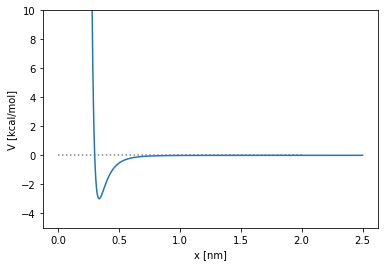

In [10]:
distance_serie = np.linspace(0.01, 2.5, 500) * unit.nanometers
potential_serie = potential(distance_serie)

plt.plot(distance_serie, potential_serie)
plt.ylim([-5,10])
plt.xlabel('x [{}]'.format(distance_serie.unit.get_symbol()))
plt.ylabel('V [{}]'.format(potential_serie.unit.get_symbol()))
plt.hlines(0, 0.0, 2.0, linestyles='dotted', color='gray')
plt.show()

Vamos a suponer que el potencial es cero desde la distancia umbral $l_{top}=2.0 \; \rm{nm}$, no parece una mala aproximación y simplifica mucho las cosas. Veamos cuanto vale el potencial en ese punto:

\begin{equation}
V(l) \approx
\begin{cases}
4 \epsilon_{red} \left[ \left( \frac{\sigma_{red}}{l} \right)^{12} - \left( \frac{\sigma_{red}}{l} \right)^{6} \right] \;\;\;\;\; si \;\;\; l \leq l_{top} \\
0 \;\;\;\;\; si \;\;\; l> l_{top}
\end{cases}
\end{equation}

In [11]:
potential(2.0*unit.nanometers) # aunque lo importante es ver el valor de la primera derivada (la fuerza).

Quantity(value=-0.00013668594304394545, unit=kilocalorie/mole)

Con esta aproximación podemos entonces reescribir:

\begin{equation}
\hat{Z}_{V} \approx \int_{0}^{l_{top}} 4 \pi l^{2} e^{-\frac{1}{K_{B}T}V(l)} \; dl + \left[L_{box}^{3}-\frac{4}{3}\pi l_{top}^{3}\right]
\end{equation}

Ya podemos entonces calcular el valor de la función de partición total $\hat{Z}_{V}$. Resolveremos el término integral numéricamente.

In [12]:
def zV(x):
    
    global sigma_red, epsilon_red, KbT
    
    x_aux = sigma_red/x
    Vx =  4 * epsilon_red * (x_aux**12 - x_aux**6)

    return (4*np.pi*x**2)*np.exp(-Vx/KbT)

def integral_numerica_1D (f, lim_inf, lim_sup, n_bins):
    
    delta_x = (lim_sup - lim_inf)/n_bins
    
    x = lim_inf

    for ii in range(1,n_bins):
        try:
            output += f(x)*delta_x
        except:
            output = f(x)*delta_x
        x += delta_x
    
    return output

In [13]:
ltop = 2.0 * unit.nanometers
ZV = integral_numerica_1D(zV, 0.000001*unit.nanometer, ltop, 1000)
ZV += (Lbox)**3 - (4/3)*np.pi*ltop**3

In [14]:
ZV

Quantity(value=137.69140449911023, unit=nanometer**3)

Ahora, la parte del numerador para el cálculo de la función de densidad de probabilidad de la distancia entre las dos partículas lo haremos también en coordenadas polares para que la función delta de dirac simplifique la integral:

\begin{equation}
P(l) = \frac{1}{\hat{Z}_{V}} \iiint_{-L_{box}/2}^{L_{box}/2} e^{-\frac{1}{K_{B}T}V(l)} \delta (l−\lVert \vec{u} \rVert) \; d\vec{u} = \frac{1}{\hat{Z}_{V}} e^{-\frac{1}{K_{B}T}V(l)} \phi(l) \; dl
\end{equation}

Donde aquí el valor $\phi(l)$ corresponde a la superficie de la esfera de radio $l$ circunscrita en un cubo de lado $L_{box}$ que queda dentro de dicho cubo. Resolveremos este valor también numéricamente, pero esta vez utilizando una aproximación de tipo monte carlo:

In [15]:
def portion_of_sphere_surface_inside_cube(radius, Lbox, n_mc_tries):
    
    half_Lbox = 0.5*Lbox
    
    try_in = 0

    for ii in range(n_mc_tries):
        aux=np.random.randn(3)
        norm_aux=sum(aux*aux)**.5
        point_unit_sphere=aux/norm_aux
        point_distance_sphere=radius*point_unit_sphere

        if np.all(np.abs(point_distance_sphere)*radius.unit<=half_Lbox):
            try_in+=1

    portion=try_in/n_mc_tries

    return portion

La función anterior nos ofrece una buena estimación de la fracción de superficie de la esfera de radio $l$ que queda dentro del cubo de lado $L_{box}$ en el que está circunscrita:

In [16]:
radii_serie = np.linspace(0.001, 5.0, 100)*unit.nanometers
portions_serie = []
for radius in tqdm(radii_serie):
    factor = portion_of_sphere_surface_inside_cube(radius, Lbox, 10000)
    portions_serie.append(factor)

100%|██████████| 100/100 [00:36<00:00,  2.70it/s]


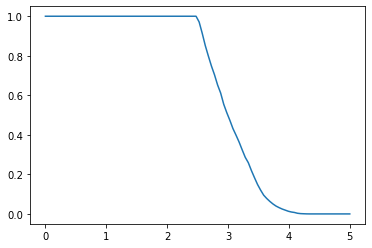

In [17]:
plt.plot(radii_serie, portions_serie)
plt.show()

Así que ya tenemos el valor de $\phi(l)$ para todo $l$:

In [18]:
areas_serie = []*unit.nanometers**2
for radius, portion in zip(radii_serie, portions_serie):
    areas_serie.append((4*np.pi*radius**2)*portion)

In [19]:
areas_serie._value = np.array(areas_serie._value)

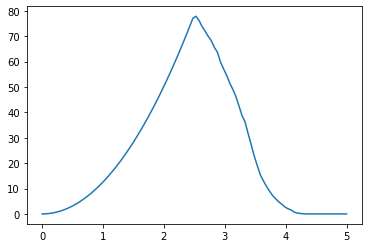

In [20]:
plt.plot(radii_serie, areas_serie)
plt.show()

Finalmente, ya podemos representar la densidad de probabilidad de que las dos partículas $A$ y $B$ se encuentren a distancia $l$ en una caja cúbica de lado $L_{box}$ de condiciones de contorno periódicas:

In [21]:
l_serie = np.linspace(0.000001, 5.0 , 500) * unit.nanometer
zVl_serie = []*unit.nanometer**2
for l in tqdm(l_serie):
    portion = portion_of_sphere_surface_inside_cube(l, Lbox, 20000)
    l_aux = sigma_red/l
    Vl =  4*epsilon_red*(l_aux**12-l_aux**6)
    zVl = (4*np.pi*l**2)*portion*np.exp(-Vl/KbT)
    zVl_serie.append(zVl)

Pl_serie = zVl_serie/ZV
Pl_serie._value = np.array(Pl_serie._value)

100%|██████████| 500/500 [06:38<00:00,  1.25it/s]


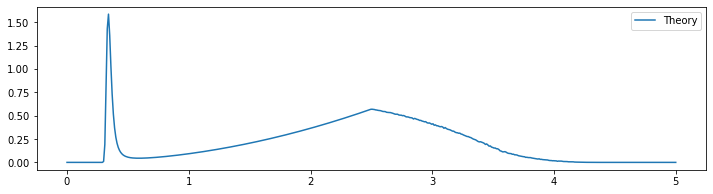

In [22]:
plt.figure(figsize=[12,3])
plt.plot(l_serie, Pl_serie, label='Theory')
plt.legend()
plt.show()

/home/diego/MyMachine/locals/miniconda/envs/UIBCDF-Academia/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


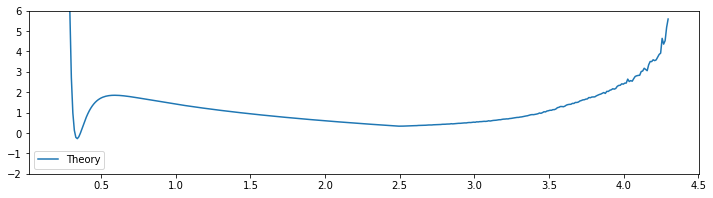

In [23]:
Fl_theo = -KbT*np.log(Pl_serie)

plt.figure(figsize=[12,3])
plt.plot(l_serie, Fl_theo.in_units_of(unit.kilocalories_per_mole), label='Theory')
plt.ylim([-2,6])
plt.legend()
plt.show()

¿Te recuerda al sistema de doble pozo que vimos anteriormente? Ya podemos calcular las magnitudes termodinámicas $P_\rm{on}$, $P_\rm{off}$, $K_\rm{D}$, $K_\rm{A}$, $\Delta F_\rm{binding}$, ... Pero antes, hagámosnos una pregunta. ¿Donde está la distancia limite por debajo de la cual consideramos el complejo AB formado?¿Cómo definimos el sistema asociado y el disociado? Con el potencial de tipo doble pozo era muy claro... ¿Y ahora? ¿Hacemos uso de la barrera que vemos en la energía libre?

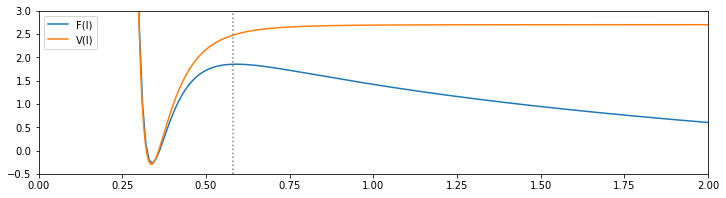

In [24]:
plt.figure(figsize=[12,3])
plt.plot(l_serie, Fl_theo.in_units_of(unit.kilocalories_per_mole), label='F(l)')
plt.plot(distance_serie, potential_serie+2.7*unit.kilocalorie_per_mole, label='V(l)')
plt.xlim([0,2])
plt.ylim([-0.5,3])
plt.vlines(0.58, -0.5, 4.0, linestyle=':', color='gray')
plt.legend()
plt.show()


Hemos situado una linea punteada sobre la coordenada $l_{b}$ de la barrera de la energía libre para saber cómo es la energía potencial en ese punto. A temperatura '0' esta claro que podríamos discutir si $l_{b}$ es o no una buena distancia umbral para definir lo que consideramos como estado "unido". Si a temperatura cero ponemos 1000 pares de partículas A-B a una distancia $l_{b}$, esta claro que el 100% de los pares relajaran al complejo AB formado. No parece un buen límite, ¿cierto? Ahora, si vemos la barrera del doble pozo de las unidades anteriores y ponemos sobre ella 1000 pares de partículas A-B a una temperatura próxima a cero, aproximadamente la mitad de los pares relajarán a su estructura asociada y la otra mitad relajará a su estructura disociada. No parece una definición rigursa de barrera pero si es muy intuitiva. Entonces, si ponemos a 300K 1000 pares A-B a una distancia $l_{b}$... ¿Será equiparable la población que antes visitará el estado "asociado" antes que el "disociado" a la que visitará antes el "disociado" que el "asociado"? ¿Será cierto esto para cualquier paisaje de energía libre? ¿Nos sirve entonces la energía potencial para definir el estado "unido" o "asociado" de un complejo molecular a cierta temperatura?

Pongamos entonces la distancia de separación entre el estado asociado AB y el estado disociado A+B en $l_{b}$ para el cálculo de $P_\rm{ON}$:

In [26]:
lb=0.58*unit.nanometers

In [32]:
P_on = 0.0

l_serie = np.linspace(0.000001, lb._value , 100) * unit.nanometer
dl = np.mean(l_serie[1:]-l_serie[:-1])

for l in l_serie:
    portion = 1.0
    l_aux = sigma_red/l
    Vl =  4*epsilon_red*(l_aux**12-l_aux**6)
    zVl = (4*np.pi*l**2)*portion*np.exp(-Vl/KbT)
    P_on += zVl*dl/ZV

P_off = 1-P_on

In [33]:
P_on

0.09696067858305978

In [35]:
P_off

0.9030393214169402

De esta manera, la energía libre de unión de este sistema es:

\begin{equation}
\Delta F_{binding} = F_{\rm{on}} - F_{\rm{off}} = -K_{B}T ln(P_{\rm{on}}/P_{\rm{off}})
\end{equation}

In [36]:
Fbinding = - KbT*np.log(P_on/P_off)

In [38]:
Fbinding.in_units_of(unit.kilocalories_per_mole)

Quantity(value=1.330310388419633, unit=kilocalorie/mole)

Veamos qué sucede cuando caracterizamos la termodinámica del proceso de unión de A y B mediante una simulación de dinámica molecular de fuerza bruta. Antes, una pregunta ¿Cómo afecta el parámetro de fricción o amortiguamiento del baño térmico de la dinámica de Langevin? ¿Obtendremos distintos valores de $P_{\rm{on}}$ variando el amortiguamiento? ¿Por qué? ¿Depende la energía libre de unión de A y B de la fricción o amortiguamiento?

In [25]:
osystem = TwoLJParticles(atom_1='Dummy_A', atom_2='Dummy_B',
                         box=[[5.0, 0.0, 0.0], [0.0, 5.0, 0.0], [0.0, 0.0, 5.0]]*unit.nanometers)

In [43]:
osystem.parameters

{'mass_1': Quantity(value=40.0, unit=dalton),
 'sigma_1': Quantity(value=2.0, unit=angstrom),
 'epsilon_1': Quantity(value=2.0, unit=kilocalorie/mole),
 'mass_2': Quantity(value=120.0, unit=dalton),
 'sigma_2': Quantity(value=4.0, unit=angstrom),
 'epsilon_2': Quantity(value=4.5, unit=kilocalorie/mole),
 'box': Quantity(value=[[5.0, 0.0, 0.0], [0.0, 5.0, 0.0], [0.0, 0.0, 5.0]], unit=nanometer),
 'cutoff_distance': Quantity(value=12.0, unit=angstrom),
 'switching_distance': Quantity(value=9.0, unit=angstrom)}

In [44]:
temperature

Quantity(value=300, unit=kelvin)

In [45]:
time= 50*unit.nanoseconds
saving_timestep = 1.0*unit.picoseconds
integration_timestep = 5.0*unit.femtoseconds
friction=5.0/unit.picoseconds

In [46]:
initial_coordinates = np.zeros([2,3])*unit.nanometers
initial_coordinates[0,:] = 1.0*unit.nanometers
initial_coordinates[1,:] = 2.0*unit.nanometers

traj_dict = langevin_NVT(osystem, time=time, saving_timestep=saving_timestep,
                          integration_timestep=integration_timestep, friction=friction,
                          temperature=temperature, initial_coordinates=initial_coordinates)

100%|█████████▉| 9999900/9999999 [16:17<00:00, 10225.52it/s]


Tomemos la distancia entre los dos átomos como coordenada de reacción y construyamos, con los datos de la trayectoria, el paisaje de energía libre sobre esa coordenada de reacción:

In [47]:
distance = msm.distance(traj_dict, selection=0, selection_2=1, pbc=True)

In [48]:
def occupation_probability_density_1d(traj_x, x_range, n_bins):
    delta_x = (x_range[1]-x_range[0])/n_bins
    frequency = np.zeros(n_bins, dtype=int)
    for x in traj_x:
        bin_visited = int((x-x_range[0])/delta_x)
        frequency[bin_visited]+=1
    x_bins_centers = (x_range[0]+0.5*delta_x) + delta_x*np.arange(n_bins)
    bins_probability_density = (1.0/delta_x)*(frequency/frequency.sum())
    return x_bins_centers, bins_probability_density

In [49]:
x_center_bin, px = occupation_probability_density_1d(distance[:,0,0],
                                                     [0.0,5.0]*unit.nanometers, 200)

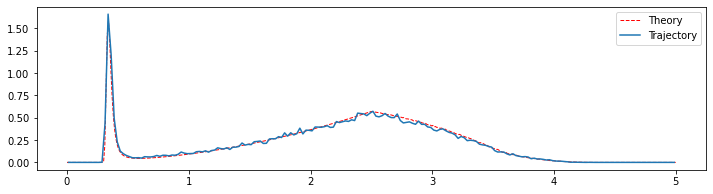

In [58]:
plt.figure(figsize=[12,3])
l_serie = np.linspace(0.000001, 5.0 , 500) * unit.nanometer
plt.plot(l_serie, Pl_serie, label='Theory', color='red', linestyle='--', linewidth=1.0)
plt.plot(x_center_bin, px, label='Trajectory')
plt.legend()
plt.show()

/home/diego/MyMachine/locals/miniconda/envs/UIBCDF-Academia/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


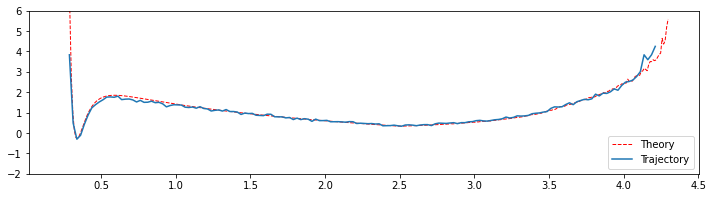

In [61]:
Fx_traj = -KbT*np.log(px)

plt.figure(figsize=[12,3])
plt.plot(l_serie, Fl_theo.in_units_of(unit.kilocalories_per_mole),
         label='Theory', color='red', linestyle='--', linewidth=1.0)
plt.plot(x_center_bin, Fx_traj.in_units_of(unit.kilocalories_per_mole), label='Trajectory')

plt.ylim([-2,6])
plt.legend()
plt.show()

Por último ya podemos calcular la energía libre de unión entre A y B en una caja cúbica de condiciones de contorno periódicas.

In [65]:
m = distance.shape[0]
m_on = np.sum(distance<=lb)
P_on_traj = m_on/m
P_off_traj = 1.0 - P_on_traj

In [66]:
P_on_traj

0.11254

In [67]:
Fbinding_traj = - KbT*np.log(P_on_traj/P_off_traj)

In [69]:
Fbinding_traj.in_units_of(unit.kilocalories_per_mole)

Quantity(value=1.231105669655766, unit=kilocalorie/mole)

Entre el valor teórico y la estimación obtenida de la simulación de 50 ns tenemos una discrepancia de:

In [70]:
Fbinding_traj.in_units_of(unit.kilocalories_per_mole) - Fbinding.in_units_of(unit.kilocalories_per_mole)

Quantity(value=-0.09920471876386694, unit=kilocalorie/mole)

Para terminar unas últimas preguntas:
- Si observas el gráfico de la densidad de probabilidad de la distancia entre A y B, $P(l)$, verás que hay un mínimo entre 2 y 3 nm. Existe una distancia más probable entre A y B cuando están disociadas ¿Cúal es la interacción que estabiliza esa conformación?¿Si no hay contribución entálpica, será que estamos hablando de la conformación más entrópica? Así que vemos entonces que tenemos dos mínimos de la energía libre. En este caso uno, en el estado 'ON', básicamente entálpico y muy poco entrópico. Y otro, en el estado 'OFF', completamente entrópico.
- ¿Depende la energía libre de unión entre A y B del tamaño de la caja? ¿Dependerá entonces la energía libre de unión de la concentración? Si no variamos el tamaño de la caja, pero ponemos otra partícula A y otra B. ¿Tendrá el sistema una energía libre de unión distinta?
- ¿A qué crees que se debe la discrepancia de 0.1 kcal/mol entre la estimación de la energía libre de unión de la simulación y el cálculo de mecánica estadística?¿Es mucho?¿Cuanto es 1 kcal/mol?¿Qué podemos hacer con esa energía libre?